In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('lib')
from lib.read_data import *
import os

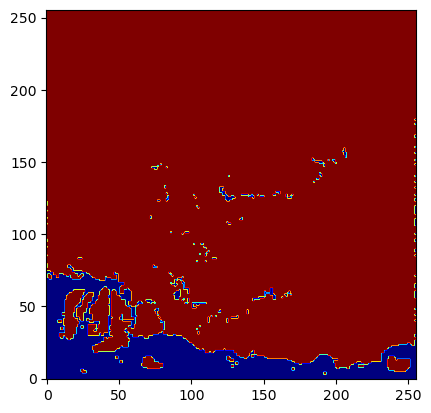

In [15]:
N = 256
frame = 100
dir = f"{DATA_PATH}/dambreak_N{N}_200"
flags = read_flags(f"{dir}/flags_{frame}.bin")
plt.imshow(flags.reshape(N, N).T, origin='lower', cmap='jet')
plt.show()

In [16]:
from scipy.ndimage import label
structure = np.ones((3, 3))
labeled, ncomponents = label((flags == 2).reshape(N, N), structure)

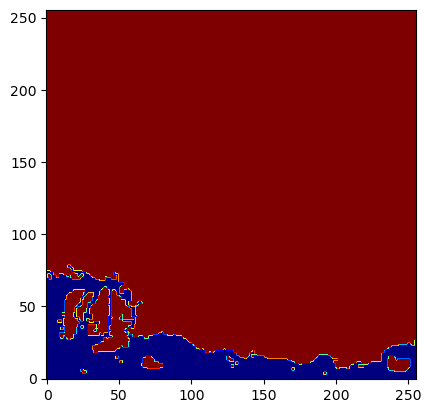

In [17]:
window_size = 50
for i in range(1, ncomponents+1):
    label1 = np.where(labeled == i)
    if len(label1[0]) < window_size:
        labeled[label1] = 0
flags_denoised = np.where(labeled == 0, 3, 2)
plt.imshow(flags_denoised.reshape(N, N).T, origin='lower', cmap='jet')
plt.show()

In [30]:
from lib.create_dataset import *

flags_denoised = flags_denoised.ravel()

rhs = load_vector(f"{dir}/div_v_star_{i}.bin", dtype='d')
rhs_denoised = np.where(flags_denoised==2, rhs, 0.0)
A = readA_sparse(f"{dir}/A_{i}.bin", dtype='d')

len(np.argwhere(rhs ==0)), len(np.argwhere(rhs_denoised == 0))

(58994, 60038)

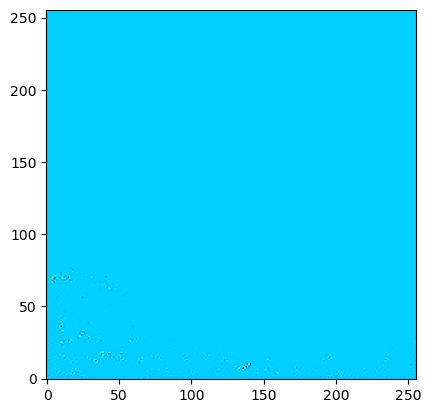

In [36]:
x = np.random.rand(N*N)
y = A @ rhs_denoised
plt.imshow(y.reshape(N, N).T , origin='lower', cmap='jet', vmax = y.max(), vmin=y.min())

In [37]:
num_ritz_vectors = 800

A_comp = compressedMat(A, flags_denoised)
rhs_de_comp = compressedVec(rhs_denoised, flags_denoised)
ritz_vals, ritz_vec = createRitzVec(A_comp, rhs_de_comp, num_ritz_vectors)

Lanczos Iteration is running...
[3.77980153 3.62846137 3.66145763 3.94603632 3.95097191 3.88450725
 3.96600462 4.01884656 3.922297   3.95106834 3.98650818 3.99130924
 4.05741659 3.95743679 3.94821333 4.10527158 4.03692522 4.0113007
 3.954319   3.8758285  4.09635613 4.00566835 3.94513029 3.97177994
 3.98684799 4.0054611  3.94778949 3.96394224 4.03663495 3.9591121
 3.95360207 4.02834572 3.92073452 3.97419603 4.03485939 4.04575273
 3.90018652 4.0071722  4.07572398 4.06604698 4.03914238 4.01143976
 3.86518684 4.01893389 3.94778242 3.96999628 4.01142012 3.97834114
 4.02108043 3.94847241 4.0682071  3.933754   4.06927013 3.99732811
 3.98817594 4.04211022 3.92311343 3.9588071  3.96494819 4.06680734
 4.04251825 3.91456442 3.98393761 3.98695851 4.0352643  3.98193803
 4.03530618 3.94544112 4.06457066 3.97812529 3.96803984 3.99733382
 4.03488736 3.96873302 3.98413539 4.02285904 4.05707309 3.98109187
 4.01476453 3.99855591 3.9985035  3.91848822 3.96691275 3.9552571
 3.90779325 4.01080323 4.11287566

In [38]:
out = f"{dir}/preprocessed/{frame}"
os.makedirs(out, exist_ok=True)
fp = np.memmap(f"{out}/ritz_{num_ritz_vectors}.dat", dtype=np.float32, mode='w+', shape=ritz_vec.shape)
fp[:] = ritz_vec
fp.flush()

In [39]:
import torch

torch.save(torch.tensor(flags_denoised, dtype=torch.float32), os.path.join(out, "flags_denoised.pt"))

/home/wlan/miniforge3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
sample_size = 800
theta = 200 # j < m/2 + theta low frequency spectrum

fluid_cells = np.where(flags_denoised == 2)[0]
b_rhs_temp = np.zeros([sample_size, len(fluid_cells)])
cut_idx = int(num_ritz_vectors/2) + theta
sample_size = sample_size
coef_matrix = np.zeros([len(ritz_vec), sample_size])
coef_matrix[:] = np.random.normal(0, 1, [len(ritz_vec), sample_size])
coef_matrix[0:cut_idx] *= 9
b_rhs_temp[:] = coef_matrix.T @ ritz_vec
for i in range(sample_size):
    b_rhs_temp[i] = b_rhs_temp[i]/np.linalg.norm(b_rhs_temp[i])
    b = torch.zeros(N**2, dtype=torch.float32)
    b[fluid_cells] = torch.tensor(b_rhs_temp[i], dtype=torch.float32)
    # s = sparse.coo_matrix((b_rhs_temp[i-l_b], (padding, np.zeros_like(padding))), shape=flags.shape+(1,), dtype=np.float32)
    torch.save(b, os.path.join(out, f"b_{i}_denoised.pt"))